In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text, select

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
    # source [3]
for i in session.query(Measurements.date).order_by(Measurements.date.desc()).limit(1):
    print(i)
    
# do the same but assign as a string variable for later use:
    # source [3]
latest_date_row = session.query(Measurements.date).order_by(sqlalchemy.desc(Measurements.date)).first()
type(latest_date_row)

latest_date = ''
for r in latest_date_row:
    print(r)
    print(type(r))
    latest_date = r

('2017-08-23',)
2017-08-23
<class 'str'>


In [10]:
# # Inspecting data types here:
# inspector = inspect(engine)
# columns = inspector.get_columns('measurement')

# for c in columns:
#     print(c['name'], c['type'])

# engine.execute(text("SELECT * FROM measurement LIMIT 3")).fetchall()

In [11]:
# Calculate the date one year from (before??) the last date in data set.
    # did not do dynamically. Issues with data types.
year_prior = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_prior

datetime.date(2016, 8, 23)

In [12]:
# returns all dates in session that are less than the latest_date 
# and greater than or equal to year prior.
yearly_data = session.query(Measurements.date).filter(Measurements.date < latest_date).\
    filter(Measurements.date >= year_prior).order_by(Measurements.date).all()


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [14]:
# query to get date and precipitiation scores:
rainfall = select([Measurements.date, Measurements.prcp]).where(Measurements.date > year_prior)
result = engine.execute(rainfall)
# result.fetchall()


In [15]:
# feed the query along with a connection object to the pd.read_sql function:
#   source: [4]
conn = engine.connect()
data_df = pd.read_sql(rainfall, conn)


#set column names and sort by date:
data_df.rename(columns= {'date': 'Date', 'prcp': 'Rainfall_total'}, inplace= True)
data_df.sort_values(by= 'Date', ascending=True)
data_df.head()

,Date,Rainfall_total
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01


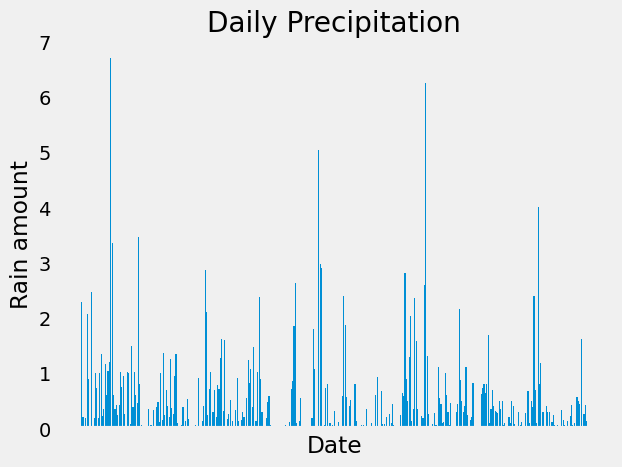

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
x_ax = data_df['Date']
y_ax = data_df['Rainfall_total']
plt.title('Daily Precipitation')
plt.xlabel('Date')

# hide the xticks for now...
plt.xticks(np.arange(len(x_ax), 3), rotation= 45)
plt.ylabel('Rain amount')


plt.grid(False)
plt.bar(x_ax, y_ax)

plt.show()



In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
data_df.describe()

,Rainfall_total
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# reviews the measurement table column headers:
stations_measurements = engine.execute(text("SELECT * FROM measurement"))
print(stations_measurements.keys())
#stations.fetchall()

# reviews the stations table headers:
stations = engine.execute(text("SELECT * FROM station"))
print(stations.keys())

RMKeyView(['id', 'station', 'date', 'prcp', 'tobs'])
RMKeyView(['id', 'station', 'name', 'latitude', 'longitude', 'elevation'])


In [19]:
# Design a query to calculate the total number of stations in the dataset
stations_count = engine.execute(text("SELECT COUNT(Station) FROM Station")).fetchall()
stations_count

[(9,)]

In [20]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = engine.execute(text("SELECT station, COUNT(date) FROM measurement GROUP BY station ORDER BY COUNT(date) DESC")).fetchall()
active_stations



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
busy_station = engine.execute(text("SELECT MIN(tobs), MAX(tobs), AVG(tobs) FROM measurement WHERE station ='USC00519281'")).fetchall()
busy_station

[(54.0, 85.0, 71.66378066378067)]

In [39]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

latest_date = engine.execute(text("SELECT MAX(date) FROM measurement WHERE station='USC00519281'")).fetchall()[0][0]
print(latest_date)

#source [5]
year_limit = (dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(year_limit)

active_temps = engine.execute(text("SELECT tobs FROM measurement WHERE station ='USC00519281' AND date >= '2016-08-18' ORDER BY date DESC")).fetchall()
#active_temps


2017-08-18
2016-08-18


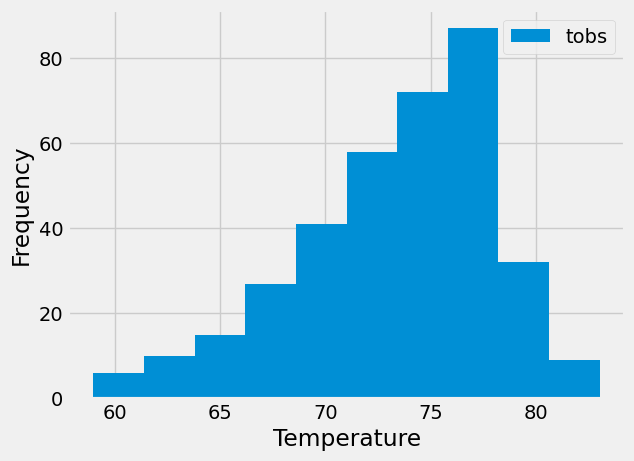

In [38]:
temperatures_df = pd.DataFrame(active_temps)
temperatures_df

# plot the DF as a histogram:

plt.hist(temperatures_df)

plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(["tobs"], loc= 'upper right')


plt.show()


# Close Session

In [40]:
# Close Session
session.close()